In [1]:
from tensorflow.keras import backend as K
K.clear_session()

import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tifffile import imread
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from sklearn.model_selection import train_test_split

import random
import numpy as np
from matplotlib import pyplot as plt

In [6]:
import os
from pathlib import Path

try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/My Drive/Colab Notebooks/martin/fluo'
  # augmented: data_path += '/aug'
except:
  import os
  from pathlib import Path
  here = os.getcwd()  # os.path.abspath(os.path.dirname(__file__))
  data_path = str(Path(here).joinpath('../data/toy/fluo'))

print('getting data from {}, folders there are: {}'.format(data_path, list(os.walk(data_path))[0][1]))

Mounted at /content/gdrive
getting data from /content/gdrive/My Drive/Colab Notebooks/martin/fluo, folders there are: ['masks', 'images', '.ipynb_checkpoints', 'aug']


In [3]:
image_size = (64, 64)  # original is 1100 x 700
input_shape = (*image_size, 1)

In [4]:
def crop_center(cropx,cropy):
    def _f(img):
        (y,x,_) = img.shape
        startx = x//2-(cropx//2)
        starty = y//2-(cropy//2)    
        return img[starty:starty+cropy,startx:startx+cropx]
    return _f

# todo: random crop

In [7]:
def get_data(imgs_path, masks_path, image_size):
    """ Get and resize train images and masks """
    
    def load_tiff(f, normalize=False):
        img = imread(f)
        img = img_to_array(img)
        img = resize(img, image_size)
        
        if normalize:  # normalize in [0, 1]
            m = min(img.ravel())
            M = max(img.ravel())
            r = M - m
            img = (img - m) / r  # todo very slow

        return img
    
    def load_image(name):
        f = str(Path(imgs_path).joinpath(name))
        return load_tiff(f, normalize=True)
    
    def load_mask(name):
        name = name.replace('img_', 'mask_')  # respective mask
        f = str(Path(masks_path).joinpath(name))
        return load_tiff(f, normalize=True)

    list_imgs = next(os.walk(imgs_path))[2]

    X = np.zeros((len(list_imgs), *input_shape), dtype=np.float32)
    y = np.zeros((len(list_imgs), *input_shape), dtype=np.float32)
    
    for i, img_name in enumerate(list_imgs):
        X[i, ..., 0] = load_image(img_name).squeeze()
        y[i] = load_mask(img_name)

    return X, y

# get data
X, y = get_data(data_path + '/images', data_path + '/masks', image_size)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)  # split train and test

print('found {} samples: {} training, {} validation'.format(len(X), len(X_train), len(X_valid)))

found 92 samples: 82 training, 10 validation


0

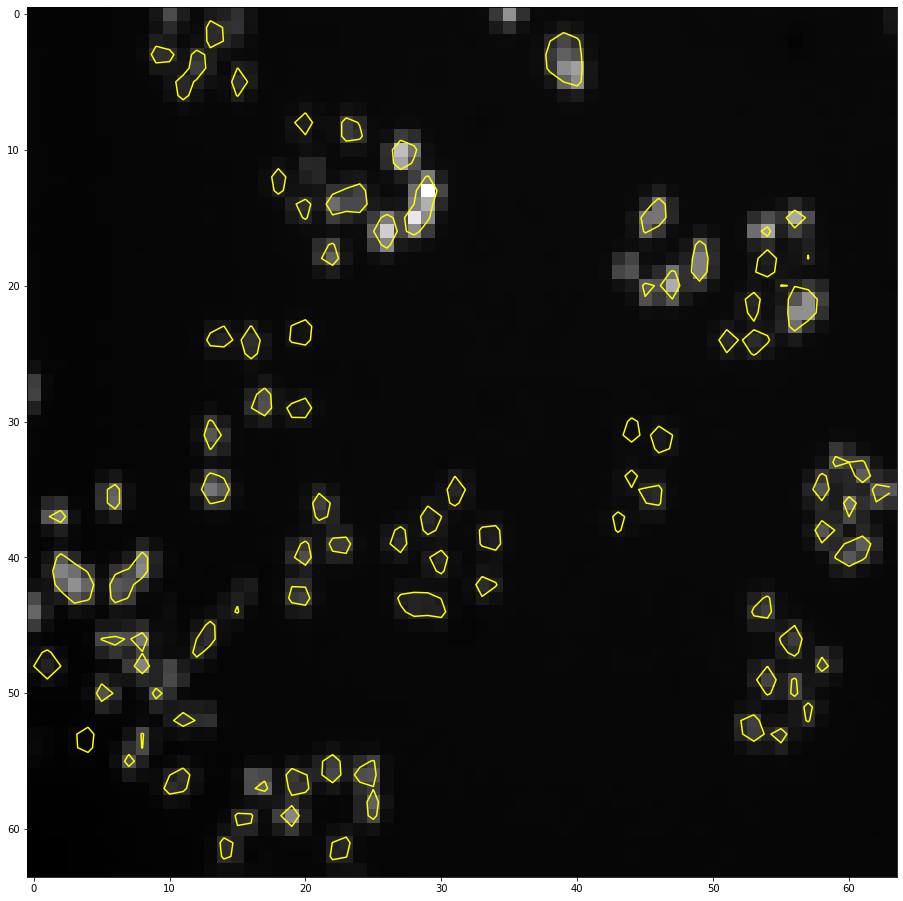

In [8]:
def plot_train_sample(X, y, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    plt.figure(figsize=(16, 16))
    plt.imshow(X[ix, ..., 0], cmap='gray')
    plt.contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    
    return ix

def plot_pred_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    ax[0].set_title('image + mask')

    ax[1].imshow(preds[ix].squeeze(), cmap='gray')
    ax[1].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    ax[1].set_title('predicted + original mask')

    return ix

def plot_results(results):
    plt.figure(figsize=(24, 8))

    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")

    plt.xlabel("epochs")
    plt.ylabel("log loss")
    plt.legend()

plot_train_sample(X_train, y_train)  # check if training data looks all right

In [14]:
def conv2d_block(n_filters, kernel_size=3, batchnorm=True):
    def _f(x):
        n_layers = 2

        for _ in range(n_layers):
            x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", padding="same")(x)
            if batchnorm:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)

        return x

    return _f


def contracting_block(n_filters, dropout, batchnorm, pooling=MaxPooling2D((2, 2))):
    def _f(x):
        x = conv2d_block(n_filters, kernel_size=3, batchnorm=batchnorm)(x)
        skip_conn = x  # save for up path

        x = pooling(x)
        x = Dropout(dropout)(x)
        return x, skip_conn

    return _f


def contracting_path(n_filters, n_layers, dropout, batchnorm):
    def _f(x):
        skip_conns = []
        current_n_filters = n_filters

        for _ in range(n_layers):
            x, s = contracting_block(current_n_filters, dropout, batchnorm)(x)

            current_n_filters *= 2
            skip_conns.append(s)

        return x, skip_conns

    return _f


def u_path(n_filters, batchnorm):
    def _f(x):
        x = conv2d_block(n_filters, kernel_size=3, batchnorm=batchnorm)(x)
        return x

    return _f


def expanding_block(n_filters, skip_conn, dropout, batchnorm):
    def _f(x):
        x = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip_conn])
        x = Dropout(dropout)(x)
        x = conv2d_block(n_filters=n_filters, kernel_size=3, batchnorm=batchnorm)(x)

        return x

    return _f


def expanding_path(n_filters, skip_conns, dropout, batchnorm):
    def _f(x):
        current_n_filters = n_filters

        for skip_conn in reversed(skip_conns):
            x = expanding_block(current_n_filters, skip_conn, dropout, batchnorm)(x)

            current_n_filters /= 2

        return x

    return _f


def final_path(n_outs):
    def _f(x):
        x = Conv2D(n_outs, (1, 1), activation='sigmoid')(x)
        return x

    return _f


def get_unet(input_img, n_filters, n_layers, dropout=0.5, batchnorm=True):
    x, skip_conns = contracting_path(n_filters, n_layers, dropout, batchnorm)(input_img)
    x = u_path(n_filters * 2 ** n_layers, batchnorm)(x)
    x = expanding_path(n_filters * 2 ** n_layers, skip_conns, dropout, batchnorm)(x)
    outputs = final_path(1)(x)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

input_img = Input(input_shape)
model = get_unet(input_img, 64, 4, dropout=0.5, batchnorm=True)
# model.summary()

In [11]:
verbose = 1
batch_size = 4
epochs = 10
best_model_weights = 'model.h5'

callbacks = [
    EarlyStopping(patience=10, verbose=verbose),
    ReduceLROnPlateau(factor=1e-1, patience=3, min_lr=1e-5, verbose=verbose),
    ModelCheckpoint(best_model_weights, monitor='loss', verbose=verbose, save_best_only=True, save_weights_only=True)
]

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.3652 - accuracy: 0.5908
Epoch 00001: loss did not improve from 0.11123
21/21 [==============================] - 4s 173ms/step - loss: 0.3652 - accuracy: 0.5908 - val_loss: 4.2470 - val_accuracy: 0.6198
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.6151
Epoch 00002: loss did not improve from 0.11123
21/21 [==============================] - 2s 99ms/step - loss: 0.1563 - accuracy: 0.6151 - val_loss: 2.3392 - val_accuracy: 0.6198
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.6151
Epoch 00003: loss did not improve from 0.11123
21/21 [==============================] - 2s 99ms/step - loss: 0.1306 - accuracy: 0.6151 - val_loss: 0.4742 - val_accuracy: 0.6198
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.6151
Epoch 00004: loss did not improve from 0.11123
21/21 [==============================] - 2s 9

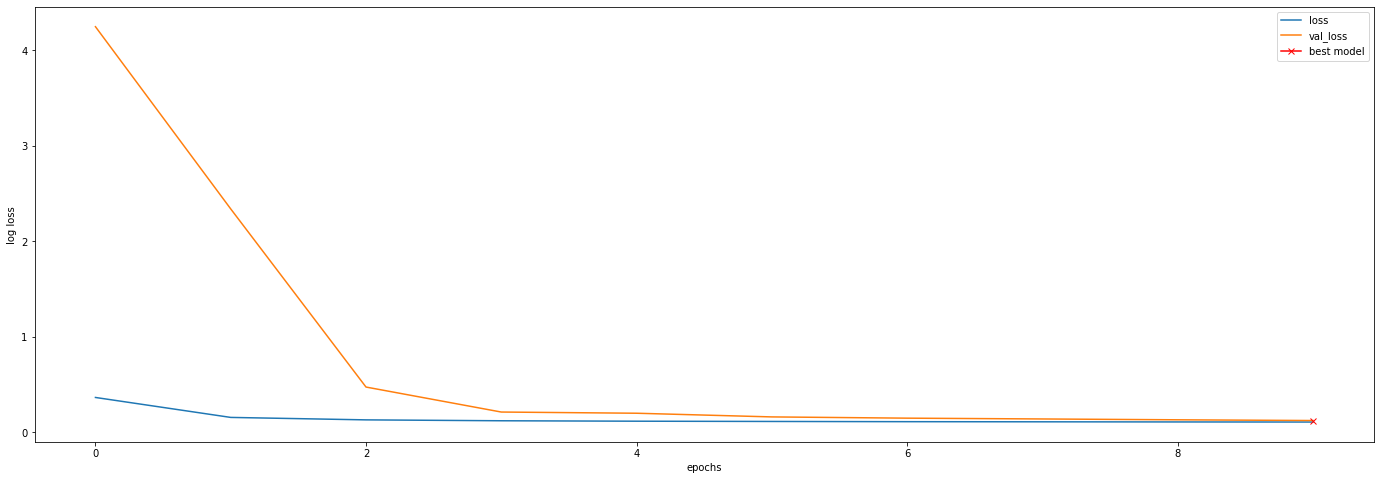

In [15]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_data=(X_valid, y_valid))

plot_results(results)

model.load_weights(best_model_weights)  # load best model
model.evaluate(X_valid, y_valid, verbose=verbose)  # evaluate on validation set

preds_train = model.predict(X_train, verbose=verbose)  # predict
preds_val = model.predict(X_valid, verbose=verbose)

7

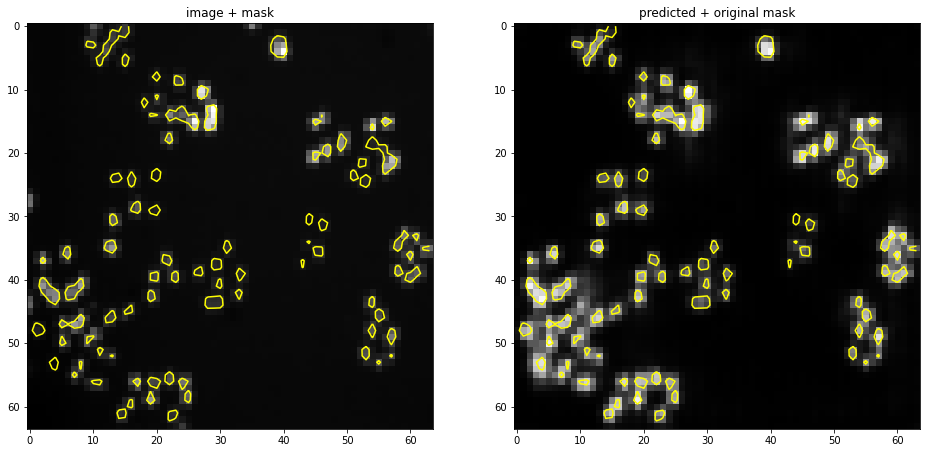

In [16]:
# plot_pred_sample(X_train, y_train, preds_train)  # predictions on training data
plot_pred_sample(X_valid, y_valid, preds_val)  # predictions on test data